In [1]:
import numpy as np
import torch

import sys
sys.path.insert(1,"../scripts")
from get_voxels import get_mol_voxels
from networks import Encoder, UNet3D, EncoderCNN, DecoderRNN, UNet3D_tcond, UNet3D_ptcond
from utils import scale_model_input

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import itertools
from diffusers import DDPMScheduler

# Copyright (C) 2019 Computational Science Lab, UPF <http://www.compscience.org/>
# Copying and distribution is allowed under AGPLv3 license

vocab_list = ["pad", "start", "end",
    "C", "c", "N", "n", "S", "s", "P", "O", "o",
    "B", "F", "I",
    "Cl", "[nH]", "Br", # "X", "Y", "Z",
    "1", "2", "3", "4", "5", "6",
    "#", "=", "-", "(", ")"  # Misc
]

vocab_i2c_v1 = {i: x for i, x in enumerate(vocab_list)}
vocab_c2i_v1 = {vocab_i2c_v1[i]: i for i in vocab_i2c_v1}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

encoder = Encoder()
encoder.load_state_dict(torch.load("../models/encoder_weights_217715.pkl", map_location="cpu"))

# net = UNet3D(in_channels=5, num_classes=5)
# net.load_state_dict(torch.load("../models/state_dict_net.pt"))
net = UNet3D_tcond(in_channels=5, num_classes=5)
net.load_state_dict(torch.load("../models/net_weights_217715.pkl", map_location="cpu"))
# Initialize the DDPM scheduler
ddpm = DDPMScheduler(num_train_timesteps=1000)

#Load Encoding and Captioning Networks (from Ligdream)
encoderCNN = EncoderCNN(5)
encoderCNN.load_state_dict(torch.load("../models/encoderCNN_weights_217715.pkl",map_location="cpu"))
# encoderCNN.load_state_dict(torch.load("../models/encoder-210000.pkl",map_location="cpu"))

decoder = DecoderRNN(512, 1024, 29, 1)
decoder.load_state_dict(torch.load("../models/decoderRNN_weights_217715.pkl", map_location='cpu'))
# decoder.load_state_dict(torch.load("../models/decoder-210000.pkl", map_location='cpu'))

use_cuda = True

encoder.to(device)
net.to(device)

encoderCNN.to(device)
decoder.to(device)

/home/chris/miniconda3/envs/diff_dream/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-09 16:20:03,766 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-05-09 16:20:03,767 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


Using device: cuda


DecoderRNN(
  (embed): Embedding(29, 512)
  (lstm): LSTM(512, 1024, batch_first=True)
  (linear): Linear(in_features=1024, out_features=29, bias=True)
)

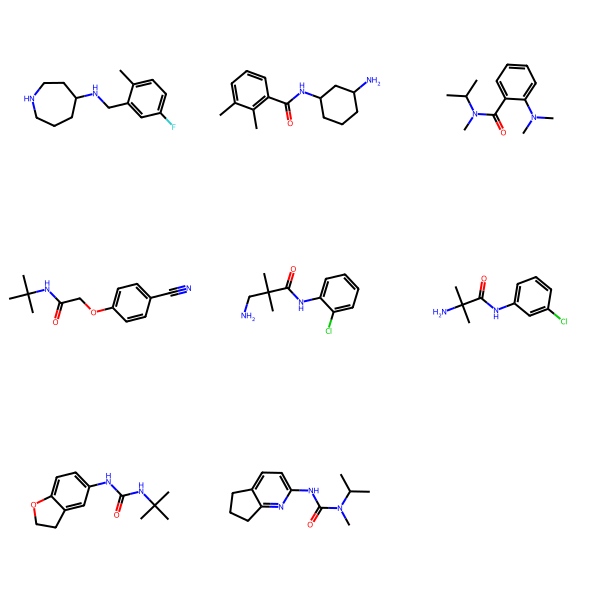

In [5]:
from rdkit.Chem import Draw
from rdkit import Chem
input_smiles = "ClC1=CC2=NC=CC(N3CCCCC3)=C2C=C1"
x_ref, y = get_mol_voxels(input_smiles)
x_ref = torch.stack([x_ref]*8)
ddpm.set_timesteps(1000)
noise = torch.randn(x_ref.shape)
x_ref = ddpm.add_noise(x_ref, noise, ddpm.timesteps[850:851])
ref_con = net(x_ref.cuda(), torch.cat([ddpm.timesteps[850:851]]*8).cuda())
embedding = encoderCNN(ref_con)

captions = torch.stack(decoder.sample(embedding)).T

gen_smiles = []
for sample in captions:
    csmile = ""
    for xchar in sample[0:]:
        if xchar == 1:
            continue
        if xchar == 2:
            break
        csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
    gen_smiles.append(csmile)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in gen_smiles])

## Visualise Pharmacophore encoder performance

/tmp/ipykernel_11390/4215437740.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pharm_pred = encoder(torch.tensor(x_ref).reshape(-1,5,24,24,24).to(device))


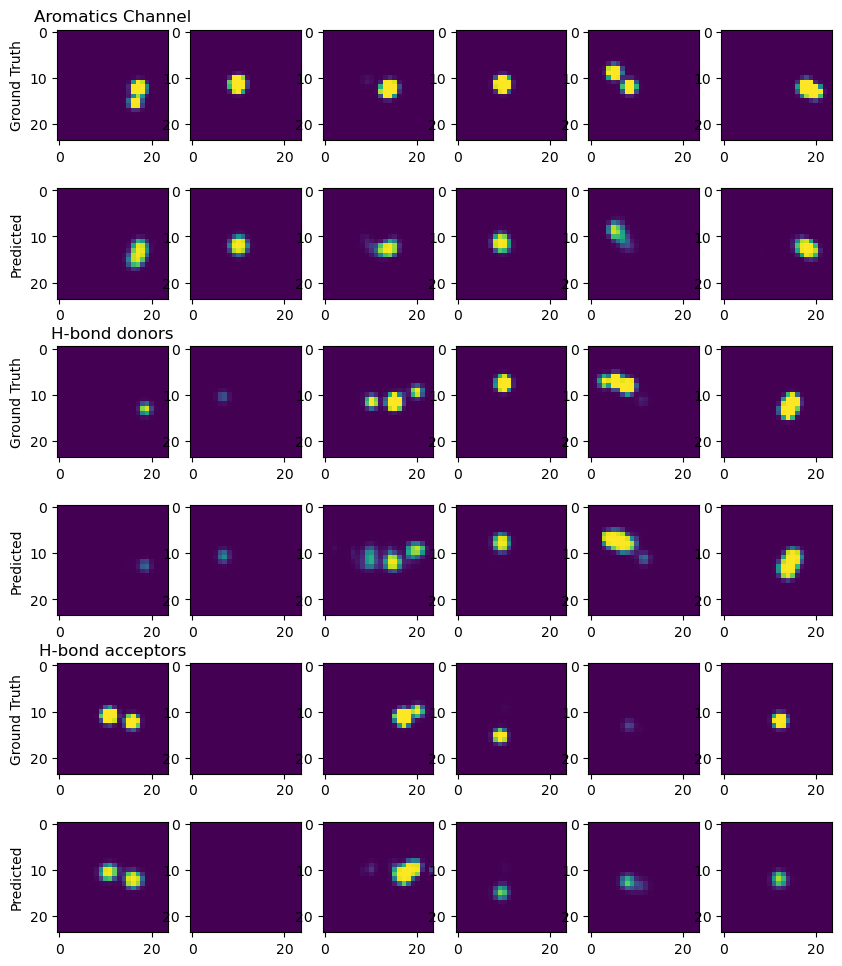

In [4]:
origs = []
pred_y = []
smiles = ["CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl",
        "CC1C(C(C)C)C2=C(C=C(C)C(C(C)=O)=C2)C1(C)C",
        "CC1=CC2=C(C(=CN2CC3=C(C(=NC=N3)N(C)C)C)C(=O)NCCO)N=C1",
        "COC(=O)NC(=O)C1=C(SC=C1)NC(=O)C2=CC=C(C=C2)C(=O)N3CCCCC3",
        "C1C2CC3CC1CC(C2)C3NC(=O)C4=CC(=CN4)C5=C(N=C(C=C5)F)F",
        "O=C(N[C@@H](CC(C)C)C(N)=O)COC1=C(Br)C2=CC=CC=C2C=C1"]
for i in range(len(smiles)):
    x_ref, y = get_mol_voxels(smiles[i])
    pharm_pred = encoder(torch.tensor(x_ref).reshape(-1,5,24,24,24).to(device))
    origs.append(y.cpu().detach().numpy())
    pred_y.append(pharm_pred.cpu().detach().numpy())


# Plot comparisons of individual slices

figs, axs = plt.subplots(nrows=6,ncols=6,figsize=(10,12))

layer = 12

for ax,i in zip(axs[0],range(6)):
    ax.imshow(origs[i][0][layer],vmin = 0, vmax = 1)
axs[0,0].set_ylabel("Ground Truth")
axs[0,0].set_title("Aromatics Channel")
for ax,i in zip(axs[1],range(6)):
    ax.imshow(pred_y[i][0][0][layer],vmin = 0, vmax = 1)
axs[1,0].set_ylabel("Predicted")

for ax,i in zip(axs[2],range(6)):
    ax.imshow(origs[i][1][layer],vmin = 0, vmax = 1)
axs[2,0].set_ylabel("Ground Truth")
axs[2,0].set_title("H-bond donors")
for ax,i in zip(axs[3],range(6)):
    ax.imshow(pred_y[i][0][1][layer],vmin = 0, vmax = 1)
axs[3,0].set_ylabel("Predicted")

for ax,i in zip(axs[4],range(6)):
    ax.imshow(origs[i][2][layer],vmin = 0, vmax = 1)
axs[4,0].set_ylabel("Ground Truth")
axs[4,0].set_title("H-bond acceptors")
for ax,i in zip(axs[5],range(6)):
    ax.imshow(pred_y[i][0][2][layer],vmin = 0, vmax = 1)
axs[5,0].set_ylabel("Predicted")

plt.show()

Plot from random noise with conditioning

In [2]:
def generate_molecule(smiles, gen_num, guidance_loss_scale = 10000, timesteps=150, vox2vox=False, get_vox = True, strength = None, n_cuts = 4):

    '''Input smiles, uses denoising u-net to generate representation then decodes.
    If vox2vox enabled then puts in a noised version of the original voxel'''

    if not vox2vox and strength != None:
        print(print("Strength ignored if generating from random noise."))
        strength=0
    elif not vox2vox:
        strength=0

    x_ref, y = get_mol_voxels(smiles)

    # y_ref = encoder(x_ref.reshape(-1,5,24,24,24).to(device))

    ddpm.set_timesteps(timesteps)

    if vox2vox:
        assert strength != None, f"Strength must be set for vox2vox"
        assert strength >=0 and strength <=1, f"Strength must be set for vox2vox"
        x = x_ref.reshape(-1,5,24,24,24).to(device)
        x = torch.cat([x]*gen_num)
        noise = torch.rand(x.shape).to(device)
        x = ddpm.add_noise(x, noise, timesteps=ddpm.timesteps[np.int64(np.ceil(timesteps*strength))])
    else:
        x = torch.randn(gen_num, 5, 24,24,24).to(device)


    y = y.reshape(-1,3,24,24,24).to(device)
    y= torch.cat([y]*gen_num)

    for i, t in enumerate(ddpm.timesteps[np.int64(np.ceil(timesteps*strength)):]):
        t = t.to(device)
        # Prepare the model input
        model_input = ddpm.scale_model_input(x, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = net(model_input, torch.cat([t.expand(1)]*model_input.shape[0]))#["sample"]
            # noise_pred = net(model_input)#["sample"]

        cond_grad = 0

        for cut in range(n_cuts):
            # Set x.requires_grad to True
            x = x.detach().requires_grad_(True)

            # Get the predicted x0
            x0 = ddpm.step(noise_pred, t, x).pred_original_sample

            # Calculate loss

            pred_pharm = encoder(x0)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(y,pred_pharm)*guidance_loss_scale
            # Get gradient
            cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

        if i % 10 == 0:
            print(loss.item())

        alpha_bar = ddpm.alphas_cumprod[i]
        x = (
            x.detach() + cond_grad * alpha_bar.sqrt() * gen_num
        )  # Note the additional scaling factor here!

        # Now step with scheduler
        x = ddpm.step(noise_pred, t, x).prev_sample

    noise_pred = noise_pred

    embedding = encoderCNN(noise_pred)
    captions = torch.stack(decoder.sample(embedding)).T.cpu().detach().numpy()
    smiles_gen = []
    for predict in captions:
        csmile = ""
        for xchar in predict[0:]:
            if xchar == 1:
                continue
            if xchar == 2:
                break
            csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
        smiles_gen.append(csmile)

    # smiles_gen = np.unique(np.array(smiles_gen))
    if get_vox:
        return noise_pred.cpu(), smiles_gen, x_ref.cpu(), y.cpu()
    else:
        return smiles_gen

In [37]:
input_smiles = "COC1=CC=C(C(C2(CCOCC2)C(NO)=O)=O)C=C1"

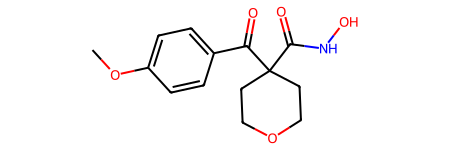

In [38]:
from rdkit import Chem
Chem.MolFromSmiles(input_smiles)

In [39]:
pred, smiles_gen, x_ref, y = generate_molecule(input_smiles,64,timesteps=50,guidance_loss_scale=10000, vox2vox=True, strength=0.9)
# input_smiles = "O=C(NO)C1(S(C2=CC=C(OC3=CC=C(Cl)C=C3)C=C2)(=O)=O)CCOCC1"
# smiles_gen = []
# while len(smiles_gen) < 512:
#     pred, smiles_g, x_ref, y = generate_molecule(input_smiles,64,timesteps=50,guidance_loss_scale=10000, vox2vox=True, strength=0.7)
#     smiles_gen = smiles_gen + list(smiles_g)
#     print(len(smiles_gen))

6936.15576171875


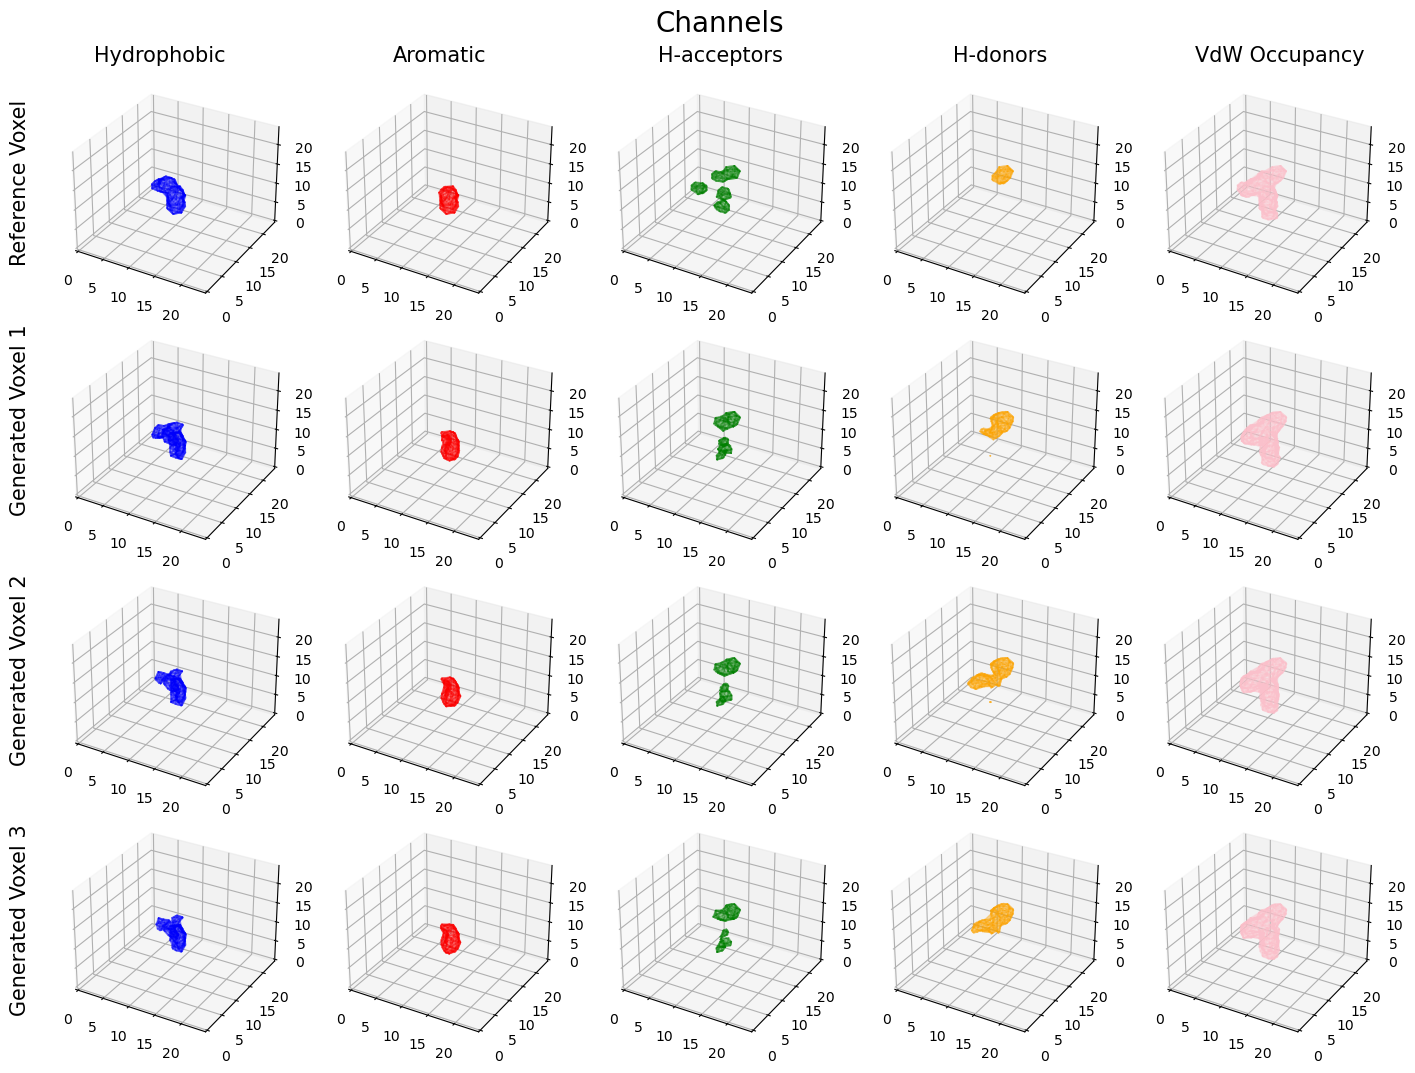

In [40]:
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D


colors = ["blue","red","green","orange","pink"]
fig = plt.figure(figsize=(14,10))

for i in range(5):
    ax = fig.add_subplot(4,5,i+1, projection='3d')
    data = x_ref[i].detach().numpy()
    try:
        threshold = 0.8
        verts, faces= measure.marching_cubes_classic(data, threshold)
        mesh = Poly3DCollection(verts[faces], alpha=0.2, color=colors[i])
        ax.add_collection3d(mesh)
        ax.set_xlim(0, 24)
        ax.set_ylim(0, 24)
        ax.set_zlim(0, 24)
    except:
        mesh = Poly3DCollection(np.random.normal(0,0.01,verts[faces].shape), alpha=0.2, color=colors[i])
        ax.add_collection3d(mesh)
        continue

k = 6
for j in range(3):
    for i in range(5):
        ax = fig.add_subplot(4,5,k, projection='3d')
        data = pred[j][i].detach().numpy()
        try:

            threshold = 0.8
            verts, faces= measure.marching_cubes_classic(data, threshold)


            mesh = Poly3DCollection(verts[faces], alpha=0.2, color=colors[i])
            ax.add_collection3d(mesh)
            ax.set_xlim(0, 24)
            ax.set_ylim(0, 24)
            ax.set_zlim(0, 24)
            k += 1
        except:
            mesh = Poly3DCollection(np.random.normal(0,0.01,verts[faces].shape), alpha=0.2, color=colors[i])
            ax.add_collection3d(mesh)
            k += 1
            continue

fig.text(0,0.8,"Reference Voxel", fontsize=15, rotation=90, ha = "center")
fig.text(0,0.55,"Generated Voxel 1", fontsize=15, rotation=90, ha = "center")
fig.text(0,0.3,"Generated Voxel 2", fontsize=15, rotation=90, ha = "center")
fig.text(0,0.05,"Generated Voxel 3", fontsize=15, rotation=90, ha = "center")

fig.text(0.1,1,"Hydrophobic", fontsize=15,ha = "center")
fig.text(0.3,1,"Aromatic", fontsize=15, ha = "center")
fig.text(0.5,1,"H-acceptors", fontsize=15, ha = "center")
fig.text(0.7,1,"H-donors", fontsize=15, ha = "center")
fig.text(0.9,1,"VdW Occupancy", fontsize=15, ha = "center")
fig.text(0.5,1.03,"Channels", fontsize=20, ha = "center")


fig.tight_layout()
plt.show()

/home/chris/miniconda3/envs/diff_dream/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


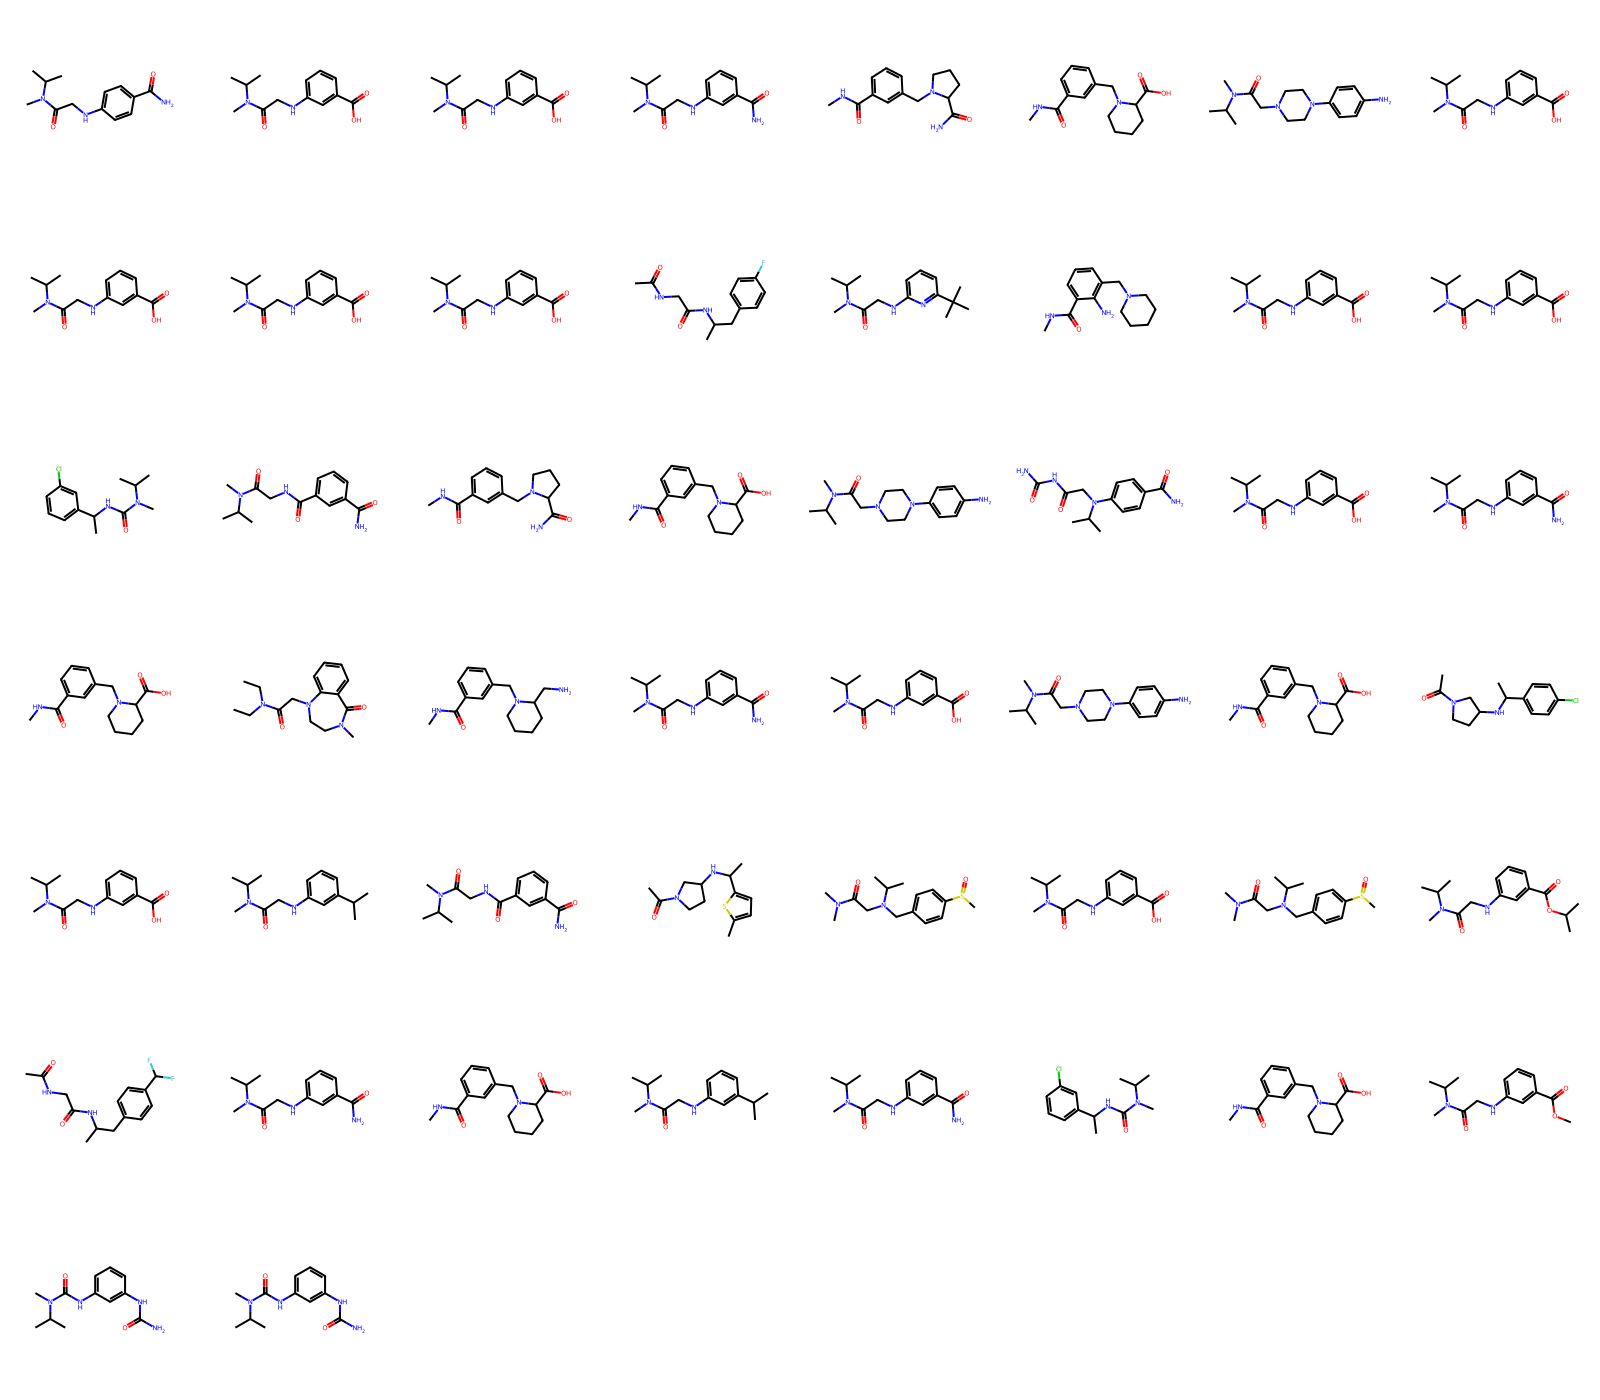

In [41]:
from rdkit import Chem
mols = [Chem.MolFromSmiles(x) for x in smiles_gen]
Chem.Draw.MolsToGridImage(mols, molsPerRow=8)

Text(0.5, 1.0, 'TPSA')

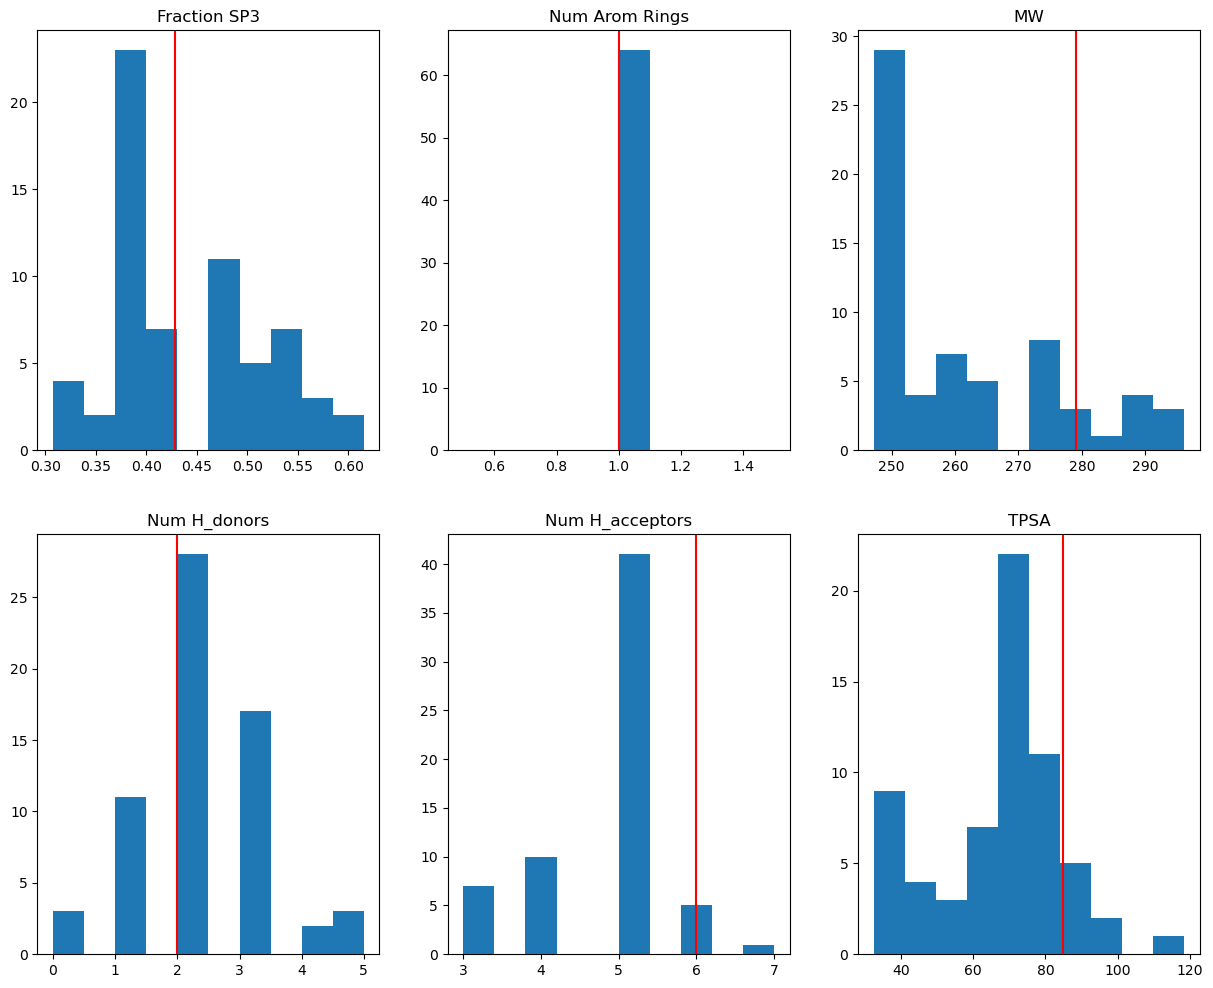

In [42]:
import pandas as pd

ref_mol = Chem.MolFromSmiles(input_smiles)

predictions = pd.DataFrame(smiles_gen, columns=["SMILES"])
predictions["mol"] = [Chem.MolFromSmiles(x) for x  in predictions.SMILES]
predictions.dropna(inplace=True)
predictions["mw"] = [Chem.rdMolDescriptors.CalcExactMolWt(mol) for mol in predictions.mol]
predictions["tpsa"] = [Chem.rdMolDescriptors.CalcTPSA(mol) for mol in predictions.mol]
predictions["sp3"]=[Chem.rdMolDescriptors.CalcFractionCSP3(mol) for mol in predictions.mol]
predictions["n_arings"]=[Chem.rdMolDescriptors.CalcNumAromaticRings(mol) for mol in predictions.mol]
predictions["h_don"] = [Chem.rdMolDescriptors.CalcNumLipinskiHBD(mol) for mol in predictions.mol]
predictions["h_acc"] = [Chem.rdMolDescriptors.CalcNumLipinskiHBA(mol) for mol in predictions.mol]
similarity = []

ref_fp = Chem.AllChem.GetMorganFingerprintAsBitVect(ref_mol,2,nBits=2048)
for mol in predictions.mol:
    fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048)
    similarity.append(Chem.AllChem.DataStructs.FingerprintSimilarity(ref_fp,fp))

predictions["similarity"] = similarity

fig, axs = plt.subplots(2,3,figsize=(15,12))

axs[0,0].hist(predictions.sp3)
axs[0,0].axvline(Chem.rdMolDescriptors.CalcFractionCSP3(ref_mol),0,1, color="red")
axs[0,0].set_title("Fraction SP3")
axs[0,1].hist(predictions.n_arings)
axs[0,1].axvline(Chem.rdMolDescriptors.CalcNumAromaticRings(ref_mol),0,1, color="red")
axs[0,1].set_title("Num Arom Rings")
axs[0,2].hist(predictions.mw)
axs[0,2].axvline(Chem.rdMolDescriptors.CalcExactMolWt(ref_mol),0,1, color="red")
axs[0,2].set_title("MW")
axs[1,0].hist(predictions.h_don)
axs[1,0].axvline(Chem.rdMolDescriptors.CalcNumLipinskiHBD(ref_mol),0,1, color="red")
axs[1,0].set_title("Num H_donors")
axs[1,1].hist(predictions.h_acc)
axs[1,1].axvline(Chem.rdMolDescriptors.CalcNumLipinskiHBA(ref_mol),0,1, color="red")
axs[1,1].set_title("Num H_acceptors")
axs[1,2].hist(predictions.tpsa)
axs[1,2].axvline(Chem.rdMolDescriptors.CalcTPSA(ref_mol),0,1, color="red")
axs[1,2].set_title("TPSA")

In [43]:
predictions.sort_values("similarity",ascending=False)

SMILES  \
55   CC(NC(=O)c1ccc(C(N)=O)cc1)C(N)C1CC1   
58   CC(NC(=O)c1ccc(C(N)=O)cc1)C(N)C1CC1   
47     CC(C)N(C)C(=O)CNc1cccc(C(=O)OC)c1   
59  CC(C)N(C)C(=O)C(=O)Nc1ccc(C(N)=O)cc1   
0       CC(C)N(C)C(=O)CNc1ccc(C(N)=O)cc1   
..                                   ...   
33       CC(C)N(C)C(=O)CNc1cccc(C(C)C)c1   
43       CC(C)N(C)C(=O)CNc1cccc(C(C)C)c1   
52       CC(C)N(C)C(=O)CNc1cccc(C(C)C)c1   
53       CC(C)N(CC(=O)N(C)C)Cc1cccc(N)c1   
12    CC(C)N(C)C(=O)CNc1cccc(C(C)(C)C)n1   

                                                 mol          mw   tpsa  \
55  <rdkit.Chem.rdchem.Mol object at 0x7f5c2ec76e40>  261.147727  98.21   
58  <rdkit.Chem.rdchem.Mol object at 0x7f5c2ec76eb0>  261.147727  98.21   
47  <rdkit.Chem.rdchem.Mol object at 0x7f5c2ec76900>  264.147393  58.64   
59  <rdkit.Chem.rdchem.Mol object at 0x7f5c1a626900>  263.126991  92.50   
0   <rdkit.Chem.rdchem.Mol object at 0x7f5c2ea2c820>  249.147727  75.43   
..                                               ...         ...    ...   
33  <rdkit.Chem.rdchem.Mol object at 0x7f5c2e6f2a50>  248.188863  32.34   
43  <rdkit.Chem.rdchem.Mol object at 0x7f5c2ec76dd0>  248.188863  32.34   
52  <rdkit.Chem.rdchem.Mol object at 0x7f5c2ec76d60>  248.188863  32.34   
53  <rdkit.Chem.rdchem.Mol object at 0x7f5c2ec76f20>  249.184112  49.57   
12  <rdkit.Chem.rdchem.Mol object at 0x7f5c18329f90>  263.199762  45.23   

         sp3  n_arings  h_don  h_acc  similarity  
55  0.428571         1      5      5    0.214286  
58  0.428571         1      5      5    0.214286  
47  0.428571         1      1      5    0.177419  
59  0.307692         1      3      6    0.175439  
0   0.384615         1      3      5    0.172414  
..       ...       ...    ...    ...         ...  
33  0.533333         1      1      3    0.129032  
43  0.533333         1      1      3    0.129032  
52  0.533333         1      1      3    0.129032  
53  0.500000         1      2      4    0.126984  
12  0.600000         1      1      4    0.123077  

[64 rows x 9 columns]

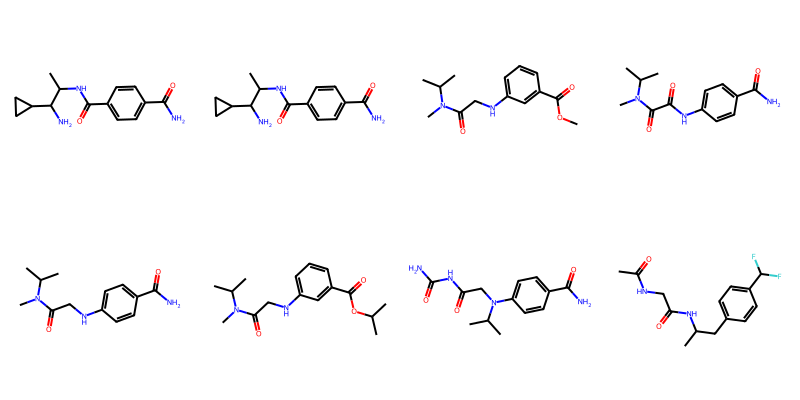

In [44]:
from rdkit import Chem
mols = [Chem.MolFromSmiles(x) for x in np.array(smiles_gen)[predictions.sort_values("similarity", ascending=False).index[:8]]]
Chem.Draw.MolsToGridImage(mols, molsPerRow=4)

ValueError: Surface level must be within volume data range.

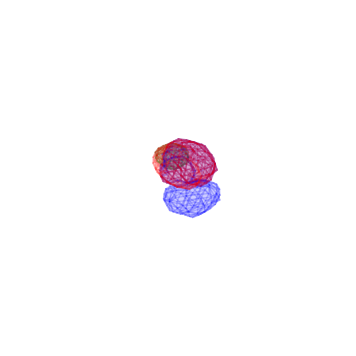

In [16]:
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D


colors = ["blue","red","green","orange","pink"]
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(1,4,1, projection='3d')
ax._axis3don = False

for i in range(5):
    data = x_ref[i].detach().numpy()
    threshold = 0.2
    verts, faces= measure.marching_cubes_classic(data, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
    ax.add_collection3d(mesh)
    ax.set_xlim(0, 24)
    ax.set_ylim(0, 24)
    ax.set_zlim(0, 24)


for j in range(1):
    ax = fig.add_subplot(1,4,j+2, projection='3d')
    ax._axis3don = False

    for i in range(5):
        data = pred[j][i].detach().numpy()
        try:
            threshold = 0.8
            verts, faces= measure.marching_cubes_classic(data, threshold)
        except:
            threshold = 0.1
            verts, faces= measure.marching_cubes_classic(data, threshold)

        mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
        ax.add_collection3d(mesh)
        ax.set_xlim(0, 24)
        ax.set_ylim(0, 24)
        ax.set_zlim(0, 24)


# fig.text(0.12,1,"Reference Mol", fontsize=15,ha = "center")
# fig.text(0.37,1,"Generated Mol 1", fontsize=15, ha = "center")
# fig.text(0.62,1,"Generated Mol 2", fontsize=15, ha = "center")
# fig.text(0.87,1,"Generated Mol 3", fontsize=15, ha = "center")



fig.tight_layout()
plt.show()


In [7]:
#Plot representations - ref + generated. Plotted as 3d isosurfaces

rep_no = 1
channel = 1 # Channels 0) Hydrophobic (alkyl, greasy etc.), 1) Aromatic 2) H-donors 3) H-acceptors 4) occupancy (VdW radii of all atoms)

test = x_ref.detach().numpy().reshape(-1,5,24,24,24)

X,Y,Z = [list(np.arange(d)) for d in (24,24,24) ]
voxels = list(itertools.product(X,Y,Z))
isoval = [test[0][channel][i][j][k] for i,j,k in voxels]
voxels = np.array(voxels)
X, Y, Z = [voxels[:,i] for i in range(3)]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value = isoval,
    isomin=0.1,
    isomax=1.0,
    opacity=0.05, # needs to be small to see through all surfaces
    surface_count=21, # needs to be a large number for good volume rendering
    ))
fig.show()

X,Y,Z = [list(np.arange(d)) for d in (24,24,24) ]
voxels = list(itertools.product(X,Y,Z))
isoval = [pred[rep_no][channel][i][j][k] for i,j,k in voxels]
X, Y, Z = [np.array(voxels)[:,i] for i in range(3)]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value = isoval,
    isomin=0.1,
    isomax=1.0,
    opacity=0.05, # needs to be small to see through all surfaces
    surface_count=64, # needs to be a large number for good volume rendering
    ))
fig.show()

# BCE with ref screening

In [24]:
x_ref, y1 = get_mol_voxels(input_smiles)

def generate_molecule_with_refs(x_ref, y1, gen_num, guidance_loss_scale = 10000, timesteps=150, vox2vox=False, get_vox = True, strength = None, n_cuts = 4):

    '''Input smiles, uses denoising u-net to generate representation then decodes.
    If vox2vox enabled then puts in a noised version of the original voxel'''

    if not vox2vox and strength != None:
        print(print("Strength ignored if generating from random noise."))
        strength=0
    elif not vox2vox:
        strength=0

    # y_ref = encoder(x_ref.reshape(-1,5,24,24,24).to(device))

    ddpm.set_timesteps(timesteps)

    if vox2vox:
        assert strength != None, f"Strength must be set for vox2vox"
        assert strength >=0 and strength <=1, f"Strength must be set for vox2vox"
        x = x_ref.reshape(-1,5,24,24,24).to(device)
        x = torch.cat([x]*gen_num)
        noise = torch.rand(x.shape).to(device)
        x = ddpm.add_noise(x, noise, timesteps=ddpm.timesteps[np.int64(np.ceil(timesteps*strength))])
    else:
        x = torch.randn(gen_num, 5, 24,24,24).to(device)


    y = y1.reshape(-1,3,24,24,24).to(device)
    y= torch.cat([y]*gen_num)

    for i, t in enumerate(ddpm.timesteps[np.int64(np.ceil(timesteps*strength)):]):
        t = t.to(device)
        # Prepare the model input
        model_input = ddpm.scale_model_input(x, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = net(model_input, torch.cat([t.expand(1)]*model_input.shape[0]))#["sample"]
            # noise_pred = net(model_input)#["sample"]

        cond_grad = 0

        for cut in range(n_cuts):
            # Set x.requires_grad to True
            x = x.detach().requires_grad_(True)

            # Get the predicted x0
            x0 = ddpm.step(noise_pred, t, x).pred_original_sample

            # Calculate loss

            pred_pharm = encoder(x0)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(y,pred_pharm)*guidance_loss_scale
            # Get gradient
            cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

        alpha_bar = ddpm.alphas_cumprod[i]
        x = (
            x.detach() + cond_grad * alpha_bar.sqrt() * gen_num
        )  # Note the additional scaling factor here!

        # Now step with scheduler
        x = ddpm.step(noise_pred, t, x).prev_sample

    noise_pred = noise_pred.cpu()

    smiles_gen = []
    for predict in noise_pred:
        embedding = encoderCNN(predict.reshape(-1,5,24,24,24))

        captions = decoder.sample_prob(embedding)
        captions = [captions]

        gen_smiles = []
        for sample in captions:
            csmile = ""
            for xchar in sample[0:]:
                if xchar == 1:
                    continue
                if xchar == 2:
                    break
                csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
            gen_smiles.append(csmile)

        smiles_gen = smiles_gen+gen_smiles

    smiles_gen = np.unique(np.array(smiles_gen))
    if get_vox:
        return noise_pred.cpu(), smiles_gen, x_ref.cpu(), y.cpu()
    else:
        return smiles_gen

Test Different Guidance Loss Scaling

In [25]:
x_refs = []
closest_reps = []
guidance_losses = [1000, 5000,10000,50000,100000]
av_mse = []
stdev = []
for gl in guidance_losses:
    pred, smiles_gen, x_ref, y2 = generate_molecule_with_refs(x_ref, y1,64,timesteps=50,guidance_loss_scale=gl, vox2vox=False)
    x_refs += [x_ref.detach().numpy()]
    mses = []
    for rep in pred:
        mses.append(torch.nn.functional.mse_loss(x_ref,rep).detach().item())
    av_mse.append(np.mean(mses))
    stdev += [np.std(mses)]
    closest_reps.append(pred[np.argmin(mses)])

import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from decimal import Decimal


colors = ["blue","red","green","orange","pink"]
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(2,3,1, projection='3d')
ax._axis3don = False

for i in range(5):
    data = x_ref[i].detach().numpy()
    threshold = 0.2
    verts, faces= measure.marching_cubes_classic(data, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
    ax.add_collection3d(mesh)
    ax.set_xlim(4, 20)
    ax.set_ylim(4, 20)
    ax.set_zlim(4, 20)


for j in range(5):
    ax = fig.add_subplot(2,3,j+2, projection='3d')
    ax._axis3don = False

    for i in range(5):
        try:
            data = closest_reps[j][i].detach().numpy()
            threshold = 0.5
            verts, faces= measure.marching_cubes_classic(data, threshold)


            mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
            ax.add_collection3d(mesh)
        except:
            mesh = Poly3DCollection(np.random.normal(0,0.01,verts[faces].shape), alpha=0.2, color=colors[i])
            ax.add_collection3d(mesh)
        ax.set_xlim(4, 20)
        ax.set_ylim(4, 20)
        ax.set_zlim(4, 20)


fig.text(0.15,0.9,"Reference Mol", fontsize=15,ha = "center") 
fig.text(0.5,0.9,"Guidance scale 1000", fontsize=15, ha = "center")
fig.text(0.85,0.9,"Guidance scale 5000", fontsize=15, ha = "center")
fig.text(0.15,0.4,"Guidance scale 10000", fontsize=15,ha = "center") 
fig.text(0.5,0.4,"Guidance scale 50000", fontsize=15, ha = "center")
fig.text(0.85,0.4,"Guidance scale 100000", fontsize=15, ha = "center")

fig.text(0.5,0.6,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[0]),Decimal(stdev[0])), fontsize=15,ha = "center") 
fig.text(0.85,0.6,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[1]),Decimal(stdev[1])), fontsize=15, ha = "center")
fig.text(0.15,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[2]),Decimal(stdev[2])), fontsize=15,ha = "center") 
fig.text(0.5,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[3]),Decimal(stdev[3])), fontsize=15, ha = "center")
fig.text(0.85,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[4]),Decimal(stdev[4])), fontsize=15, ha = "center")


fig.tight_layout()
plt.show()


NotImplementedError: Could not run 'aten::slow_conv3d_forward' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::slow_conv3d_forward' is only available for these backends: [CPU, BackendSelect, Named, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, UNKNOWN_TENSOR_TYPE_ID, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at /tmp/pip-req-build-0do2_0pt/build/aten/src/ATen/RegisterCPU.cpp:16286 [kernel]
BackendSelect: fallthrough registered at /tmp/pip-req-build-0do2_0pt/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at /tmp/pip-req-build-0do2_0pt/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
ADInplaceOrView: fallthrough registered at /tmp/pip-req-build-0do2_0pt/aten/src/ATen/core/VariableFallbackKernel.cpp:60 [backend fallback]
AutogradOther: registered at /tmp/pip-req-build-0do2_0pt/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradCPU: registered at /tmp/pip-req-build-0do2_0pt/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradCUDA: registered at /tmp/pip-req-build-0do2_0pt/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradXLA: registered at /tmp/pip-req-build-0do2_0pt/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at /tmp/pip-req-build-0do2_0pt/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradMLC: registered at /tmp/pip-req-build-0do2_0pt/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradHPU: registered at /tmp/pip-req-build-0do2_0pt/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradNestedTensor: registered at /tmp/pip-req-build-0do2_0pt/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradPrivateUse1: registered at /tmp/pip-req-build-0do2_0pt/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradPrivateUse2: registered at /tmp/pip-req-build-0do2_0pt/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradPrivateUse3: registered at /tmp/pip-req-build-0do2_0pt/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
Tracer: registered at /tmp/pip-req-build-0do2_0pt/torch/csrc/autograd/generated/TraceType_4.cpp:9909 [kernel]
Autocast: fallthrough registered at /tmp/pip-req-build-0do2_0pt/aten/src/ATen/autocast_mode.cpp:255 [backend fallback]
Batched: registered at /tmp/pip-req-build-0do2_0pt/aten/src/ATen/BatchingRegistrations.cpp:1019 [backend fallback]
VmapMode: fallthrough registered at /tmp/pip-req-build-0do2_0pt/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]


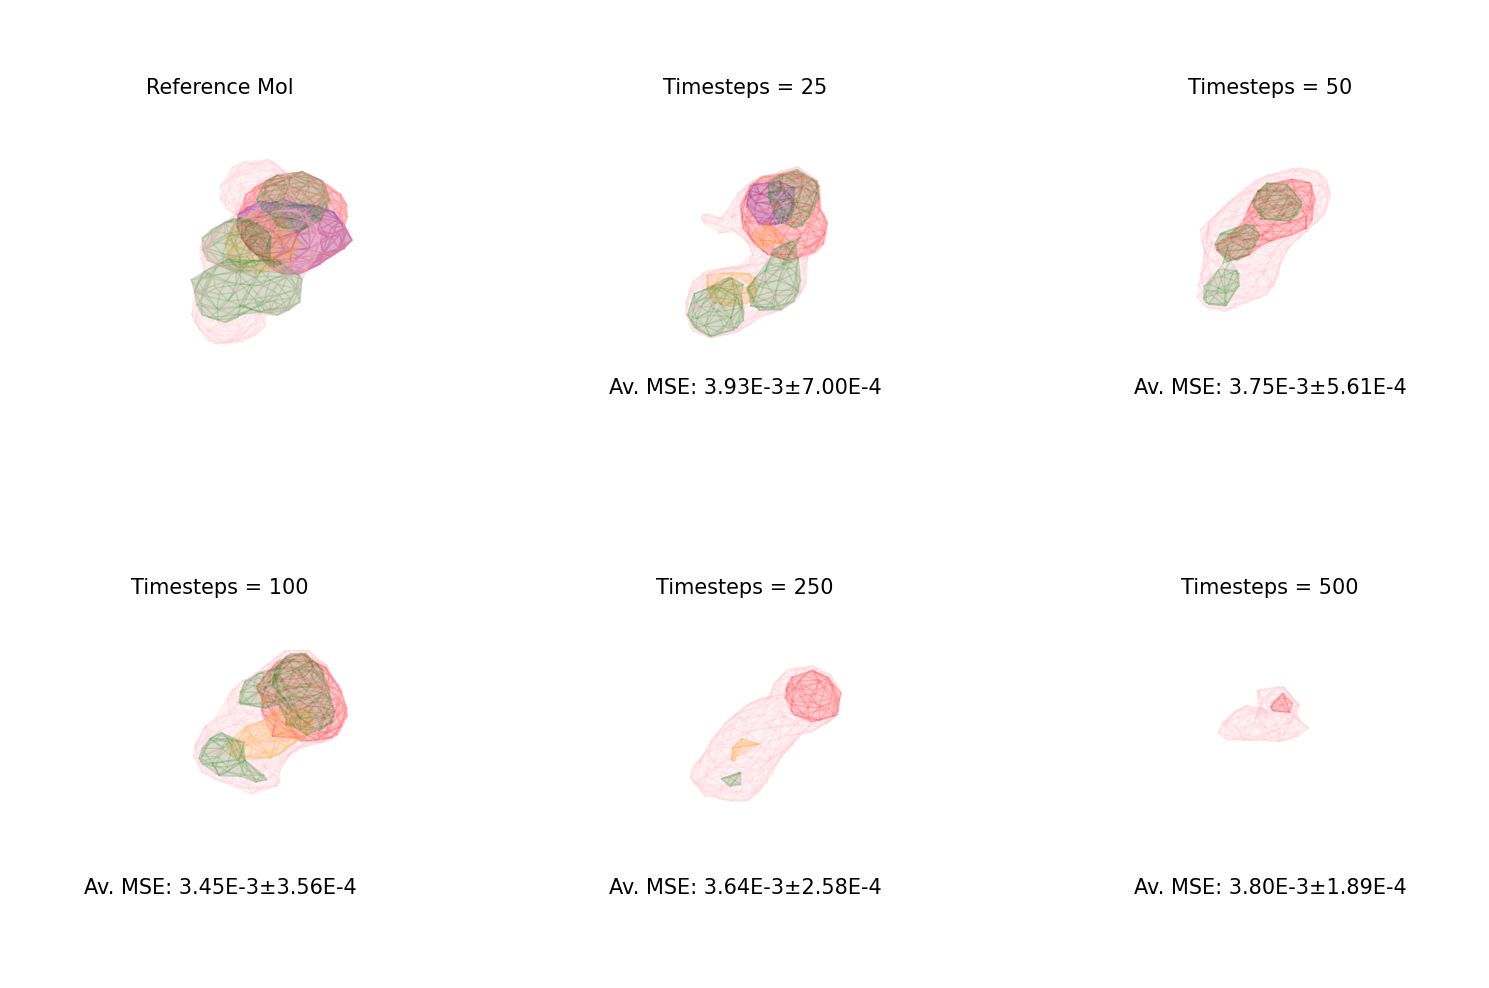

In [20]:
x_refs = []
closest_reps = []
timesteps = [25,50,100,250,500]
av_mse = []
stdev = []
for ts in timesteps:
    pred, smiles_gen, x_ref, y2 = generate_molecule_with_refs(x_ref, y1, 64,timesteps=ts,guidance_loss_scale=10000, vox2vox=False)
    x_refs += [x_ref.detach().numpy()]
    mses = []
    for rep in pred:
        mses.append(torch.nn.functional.mse_loss(x_ref,rep).detach().item())
    av_mse.append(np.mean(mses))
    stdev += [np.std(mses)]
    closest_reps.append(pred[np.argmin(mses)])

import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D


colors = ["blue","red","green","orange","pink"]
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(2,3,1, projection='3d')
ax._axis3don = False

for i in range(5):
    data = x_ref[i].detach().numpy()
    threshold = 0.2
    verts, faces= measure.marching_cubes_classic(data, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
    ax.add_collection3d(mesh)
    ax.set_xlim(4, 20)
    ax.set_ylim(4, 20)
    ax.set_zlim(4, 20)


for j in range(5):
    ax = fig.add_subplot(2,3,j+2, projection='3d')
    ax._axis3don = False

    for i in range(5):
        try:
            data = closest_reps[j][i].detach().numpy()
            threshold = 0.5
            verts, faces= measure.marching_cubes_classic(data, threshold)


            mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
            ax.add_collection3d(mesh)
        except:
            mesh = Poly3DCollection(np.random.normal(0,0.01,verts[faces].shape), alpha=0.2, color=colors[i])
            ax.add_collection3d(mesh)
        ax.set_xlim(4, 20)
        ax.set_ylim(4, 20)
        ax.set_zlim(4, 20)


fig.text(0.15,0.9,"Reference Mol", fontsize=15,ha = "center") 
fig.text(0.5,0.9,"Timesteps = 25", fontsize=15, ha = "center")
fig.text(0.85,0.9,"Timesteps = 50", fontsize=15, ha = "center")
fig.text(0.15,0.4,"Timesteps = 100", fontsize=15,ha = "center") 
fig.text(0.5,0.4,"Timesteps = 250", fontsize=15, ha = "center")
fig.text(0.85,0.4,"Timesteps = 500", fontsize=15, ha = "center")

fig.text(0.5,0.6,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[0]),Decimal(stdev[0])), fontsize=15,ha = "center") 
fig.text(0.85,0.6,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[1]),Decimal(stdev[1])), fontsize=15, ha = "center")
fig.text(0.15,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[2]),Decimal(stdev[2])), fontsize=15,ha = "center") 
fig.text(0.5,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[3]),Decimal(stdev[3])), fontsize=15, ha = "center")
fig.text(0.85,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[4]),Decimal(stdev[4])), fontsize=15, ha = "center")


fig.tight_layout()
plt.show()


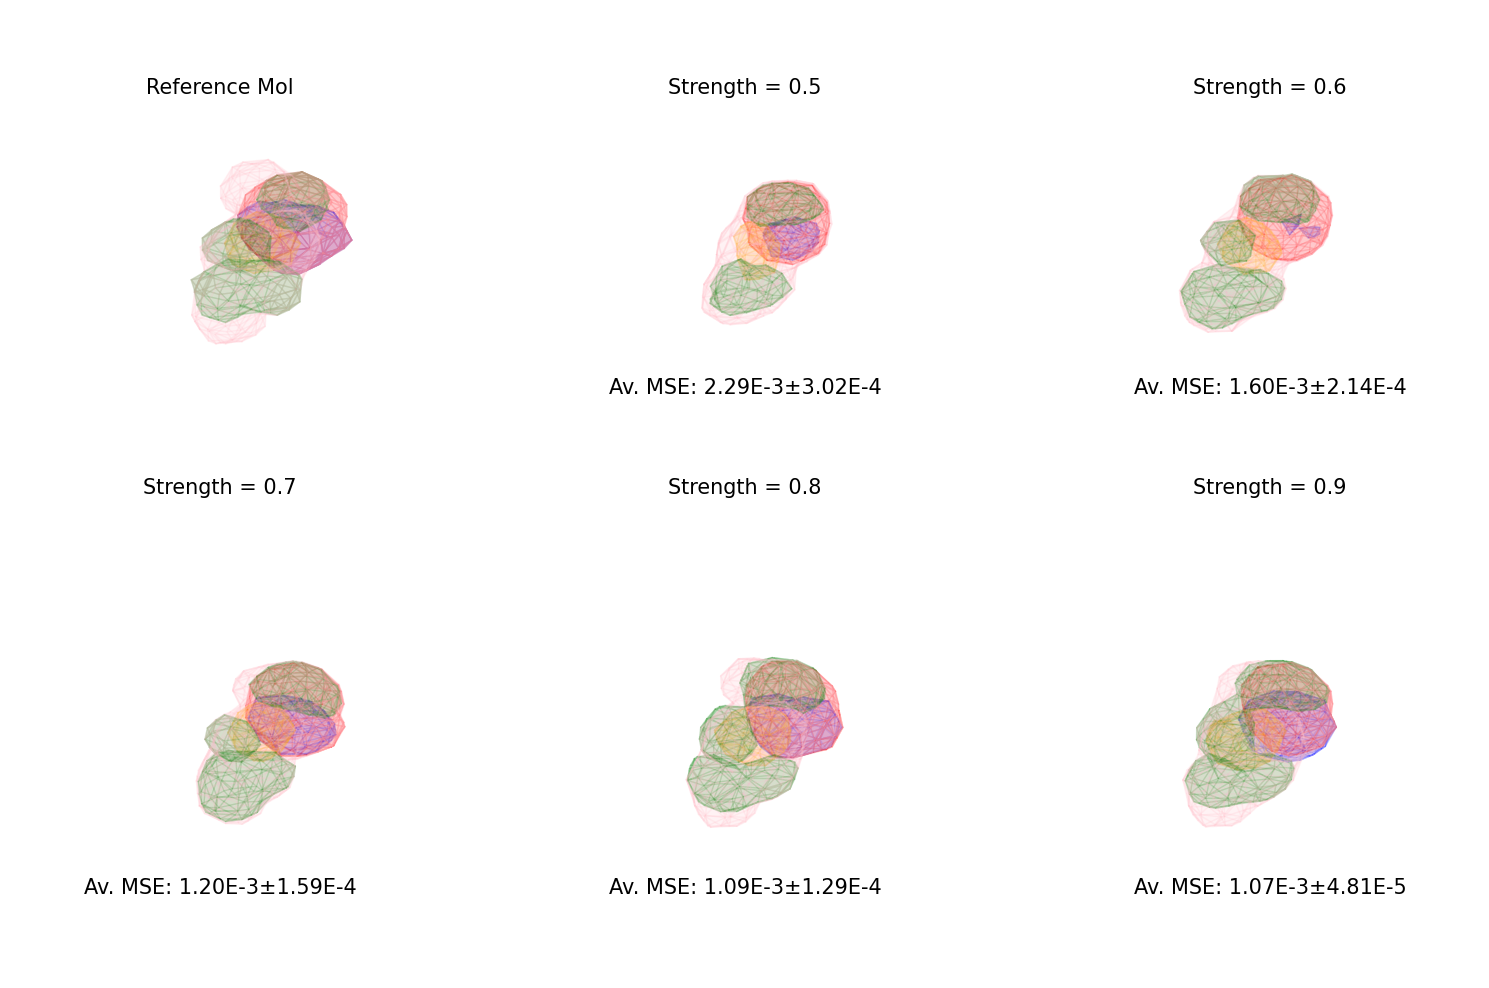

In [19]:
x_refs = []
closest_reps = []
strength = [0.5,0.6,0.7,0.8,0.9]
av_mse = []
stdev = []
for st in strength:
    pred, smiles_gen, x_ref, y2 = generate_molecule_with_refs(x_ref, y1, 64,timesteps=100,guidance_loss_scale=10000, vox2vox=True, strength=st)
    x_refs += [x_ref.detach().numpy()]
    mses = []
    for rep in pred:
        mses.append(torch.nn.functional.mse_loss(x_ref,rep).detach().item())
    av_mse.append(np.mean(mses))
    stdev += [np.std(mses)]
    closest_reps.append(pred[np.argmin(mses)])

import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D


colors = ["blue","red","green","orange","pink"]
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(2,3,1, projection='3d')
ax._axis3don = False

for i in range(5):
    data = x_refs[0][i]#.detach().numpy()
    threshold = 0.2
    verts, faces= measure.marching_cubes_classic(data, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
    ax.add_collection3d(mesh)
    ax.set_xlim(4, 20)
    ax.set_ylim(4, 20)
    ax.set_zlim(4, 20)


for j in range(5):
    ax = fig.add_subplot(2,3,j+2, projection='3d')
    ax._axis3don = False

    for i in range(5):
        try:
            data = closest_reps[j][i].detach().numpy()
            threshold = 0.5
            verts, faces= measure.marching_cubes_classic(data, threshold)


            mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
            ax.add_collection3d(mesh)
        except:
            mesh = Poly3DCollection(np.random.normal(0,0.01,verts[faces].shape), alpha=0.2, color=colors[i])
            ax.add_collection3d(mesh)
        ax.set_xlim(4, 20)
        ax.set_ylim(4, 20)
        ax.set_zlim(4, 20)


fig.text(0.15,0.9,"Reference Mol", fontsize=15,ha = "center") 
fig.text(0.5,0.9,"Strength = 0.5", fontsize=15, ha = "center")
fig.text(0.85,0.9,"Strength = 0.6", fontsize=15, ha = "center")
fig.text(0.15,0.5,"Strength = 0.7", fontsize=15,ha = "center") 
fig.text(0.5,0.5,"Strength = 0.8", fontsize=15, ha = "center")
fig.text(0.85,0.5,"Strength = 0.9", fontsize=15, ha = "center")

fig.text(0.5,0.6,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[0]),Decimal(stdev[0])), fontsize=15,ha = "center") 
fig.text(0.85,0.6,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[1]),Decimal(stdev[1])), fontsize=15, ha = "center")
fig.text(0.15,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[2]),Decimal(stdev[2])), fontsize=15,ha = "center") 
fig.text(0.5,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[3]),Decimal(stdev[3])), fontsize=15, ha = "center")
fig.text(0.85,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[4]),Decimal(stdev[4])), fontsize=15, ha = "center")


fig.tight_layout()
plt.show()


In [ ]:
x_refs = []
closest_reps = []
strength = [0.5,0.6,0.7,0.8,0.9]
av_mse = []
for st in strength:
    pred, smiles_gen, x_ref, y2 = generate_molecule_with_refs(x_ref, y1, 1,timesteps=100,guidance_loss_scale=10000, vox2vox=True, strength=1)
    x_refs += [x_ref.detach().numpy()]
    mses = []
    for rep in pred:
        mses.append(torch.nn.functional.mse_loss(x_ref,rep).detach().item())
    av_mse.append(np.mean(mses))
    closest_reps.append(pred[np.argmin(mses)])

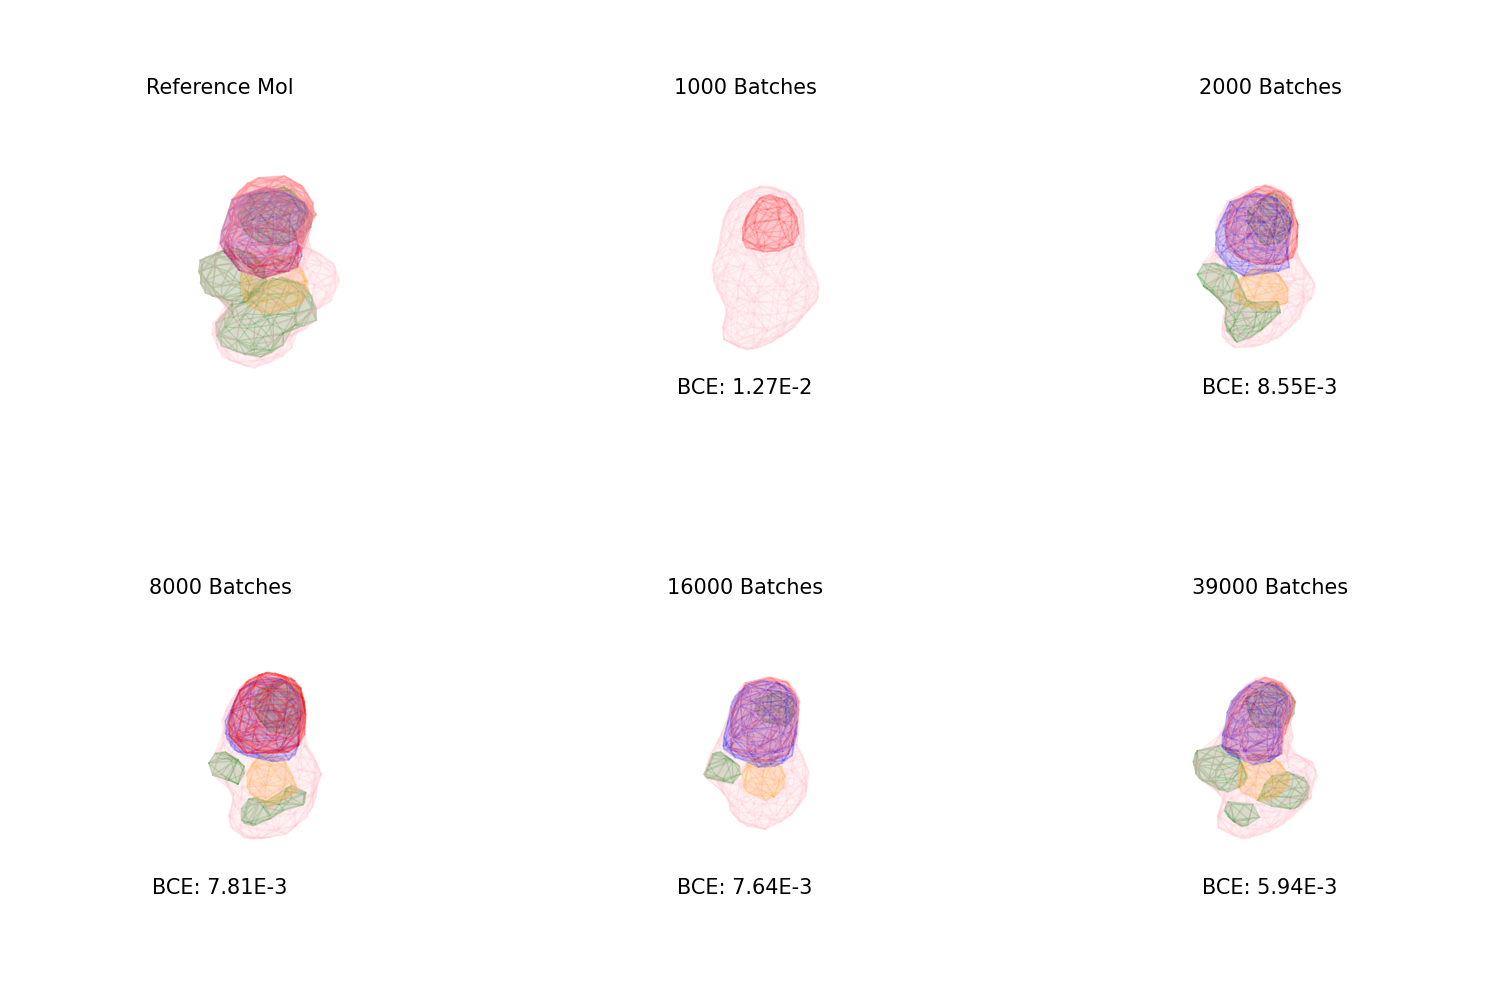

In [26]:
# input_smiles = "COC(=O)CN(C)C(=O)c1cccnc1Cl"
# x_ref, y1 = get_mol_voxels(input_smiles)
# x = x_ref.reshape(-1,5,24,24,24)
# noise = torch.randn(x.shape)

# weights = ["../models/net_weights_1000.pkl","../models/net_weights_2000.pkl","../models/net_weights_4000.pkl","../models/net_weights_16000.pkl","../models/net_weights_39000.pkl",]
# loss = torch.nn.BCELoss()

# reps = []
# bce = []

# for file in weights:
#     net.load_state_dict(torch.load(file))
#     timesteps = ddpm.timesteps[800:801]
#     noisy_x = ddpm.add_noise(x, noise, timesteps[0])
#     x_recon = net(noisy_x.to(device), timesteps.to(device))
#     bce += [loss(x_recon.cpu(), x).cpu().detach().item()]
#     reps += x_recon.cpu().detach()

import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from decimal import Decimal


colors = ["blue","red","green","orange","pink"]
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(2,3,1, projection='3d')
ax._axis3don = False

for i in range(5):
    data = x_ref[i]#.detach().numpy()
    threshold = 0.2
    verts, faces= measure.marching_cubes_classic(data, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
    ax.add_collection3d(mesh)
    ax.set_xlim(4, 20)
    ax.set_ylim(4, 20)
    ax.set_zlim(4, 20)


for j in range(5):
    ax = fig.add_subplot(2,3,j+2, projection='3d')
    ax._axis3don = False

    for i in range(5):
        try:
            data = reps[j][i].detach().numpy()
            threshold = 0.65
            verts, faces= measure.marching_cubes_classic(data, threshold)


            mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
            ax.add_collection3d(mesh)
        except:
            mesh = Poly3DCollection(np.random.normal(0,0.01,verts[faces].shape), alpha=0.2, color=colors[i])
            ax.add_collection3d(mesh)
        ax.set_xlim(4, 20)
        ax.set_ylim(4, 20)
        ax.set_zlim(4, 20)



fig.text(0.15,0.9,"Reference Mol", fontsize=15,ha = "center") 
fig.text(0.5,0.9,"1000 Batches", fontsize=15, ha = "center")
fig.text(0.85,0.9,"2000 Batches", fontsize=15, ha = "center")
fig.text(0.15,0.4,"8000 Batches", fontsize=15,ha = "center") 
fig.text(0.5,0.4,"16000 Batches", fontsize=15, ha = "center")
fig.text(0.85,0.4,"39000 Batches", fontsize=15, ha = "center")

fig.text(0.5,0.6,"BCE: {:.2E}".format(Decimal(bce[0])), fontsize=15,ha = "center") 
fig.text(0.85,0.6,"BCE: {:.2E}".format(Decimal(bce[1])), fontsize=15,ha = "center") 
fig.text(0.15,0.1,"BCE: {:.2E}".format(Decimal(bce[2])), fontsize=15,ha = "center") 
fig.text(0.5,0.1,"BCE: {:.2E}".format(Decimal(bce[3])), fontsize=15,ha = "center") 
fig.text(0.85,0.1,"BCE: {:.2E}".format(Decimal(bce[4])), fontsize=15,ha = "center") 


fig.tight_layout()
plt.show()


# Examine Results

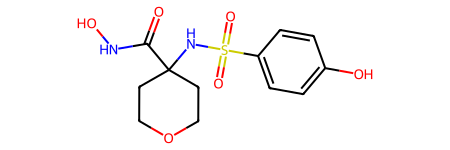

In [60]:
from rdkit import Chem

ref_mol = Chem.MolFromSmiles(input_smiles)
ref_mol

In [61]:
smiles_gen

['CCC(C)N(C)C(=O)COc1cccc(C)c1',
 'CCC1CCN1C(=O)Nc1cccc(C)n1',
 'Cc1cccc(CNC(=O)NC2CC2(C)C)n1',
 'CCC(C)CNC(=O)C(=O)c1ccc(C)cc1',
 'CCC(C)(CNCc1ccccc1OC)OC',
 'CCC1CCN1C(=O)Nc1cccc(C)n1',
 'CCC(C)NC(=O)COc1cccc(C)c1F',
 'CCC1CCN1C(=O)Nc1cccc2c1CCO2',
 'CC1CCCN1C(=O)Nc1ccccn1',
 'CCC(C)N(C)C(=O)C(=O)c1ccc(C)cc1',
 'CCC(C)NC(=O)NCc1cccc(F)c1',
 'CCC1CN(C(=O)c2cccc(F)c2C)CCO1',
 'CCC(C)NC(=O)COc1cccc(C)c1',
 'CCC(C)N(C)C(=O)C(=O)c1ccc(C)cc1',
 'Cc1cccc(CNC(=O)NC2CC23CC3)c1',
 'CCC(C)NC(=O)COc1cccc(C)c1F',
 'CC1CCCN1C(=O)Cc1cccc(F)c1',
 'CCC(C)C(=O)NCCc1cccc(C)n1',
 'CCC(N)CNC(=O)c1ccc(Cl)cc1F',
 'Cc1cccc(CCNC(=O)NC2CCC2C)n1',
 'CCC(C)CNC(=O)Cc1ccccc1NC',
 'CCC(C)NC(=O)COc1cccc(C)c1',
 'CCC(C)NC(=O)CNc1ccccc1OC',
 'CCC(C)C(=O)NCCc1cccc(OC)c1',
 'Cc1ccc(C(=O)NC2CCCCC2F)n1C',
 'CCC1CCN1C(=O)Nc1ccccc1OC',
 'Cc1cccc(CNC(=O)NC2CCCC2)n1',
 'CC1CC(C)N1C(=O)Nc1ccccn1',
 'CCC(C)N(C)C(=O)C(=O)c1ccc(C)cc1',
 'CCC(C)NC(=O)NCc1cccc(C)n1',
 'CC1CCN(C(=O)Nc2ccccn2)CC1F',
 'CCC(C)C(=O)NCC(O)c1ccccc1F',
 '

/home/chris/miniconda3/envs/diff_dream/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning:

Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.



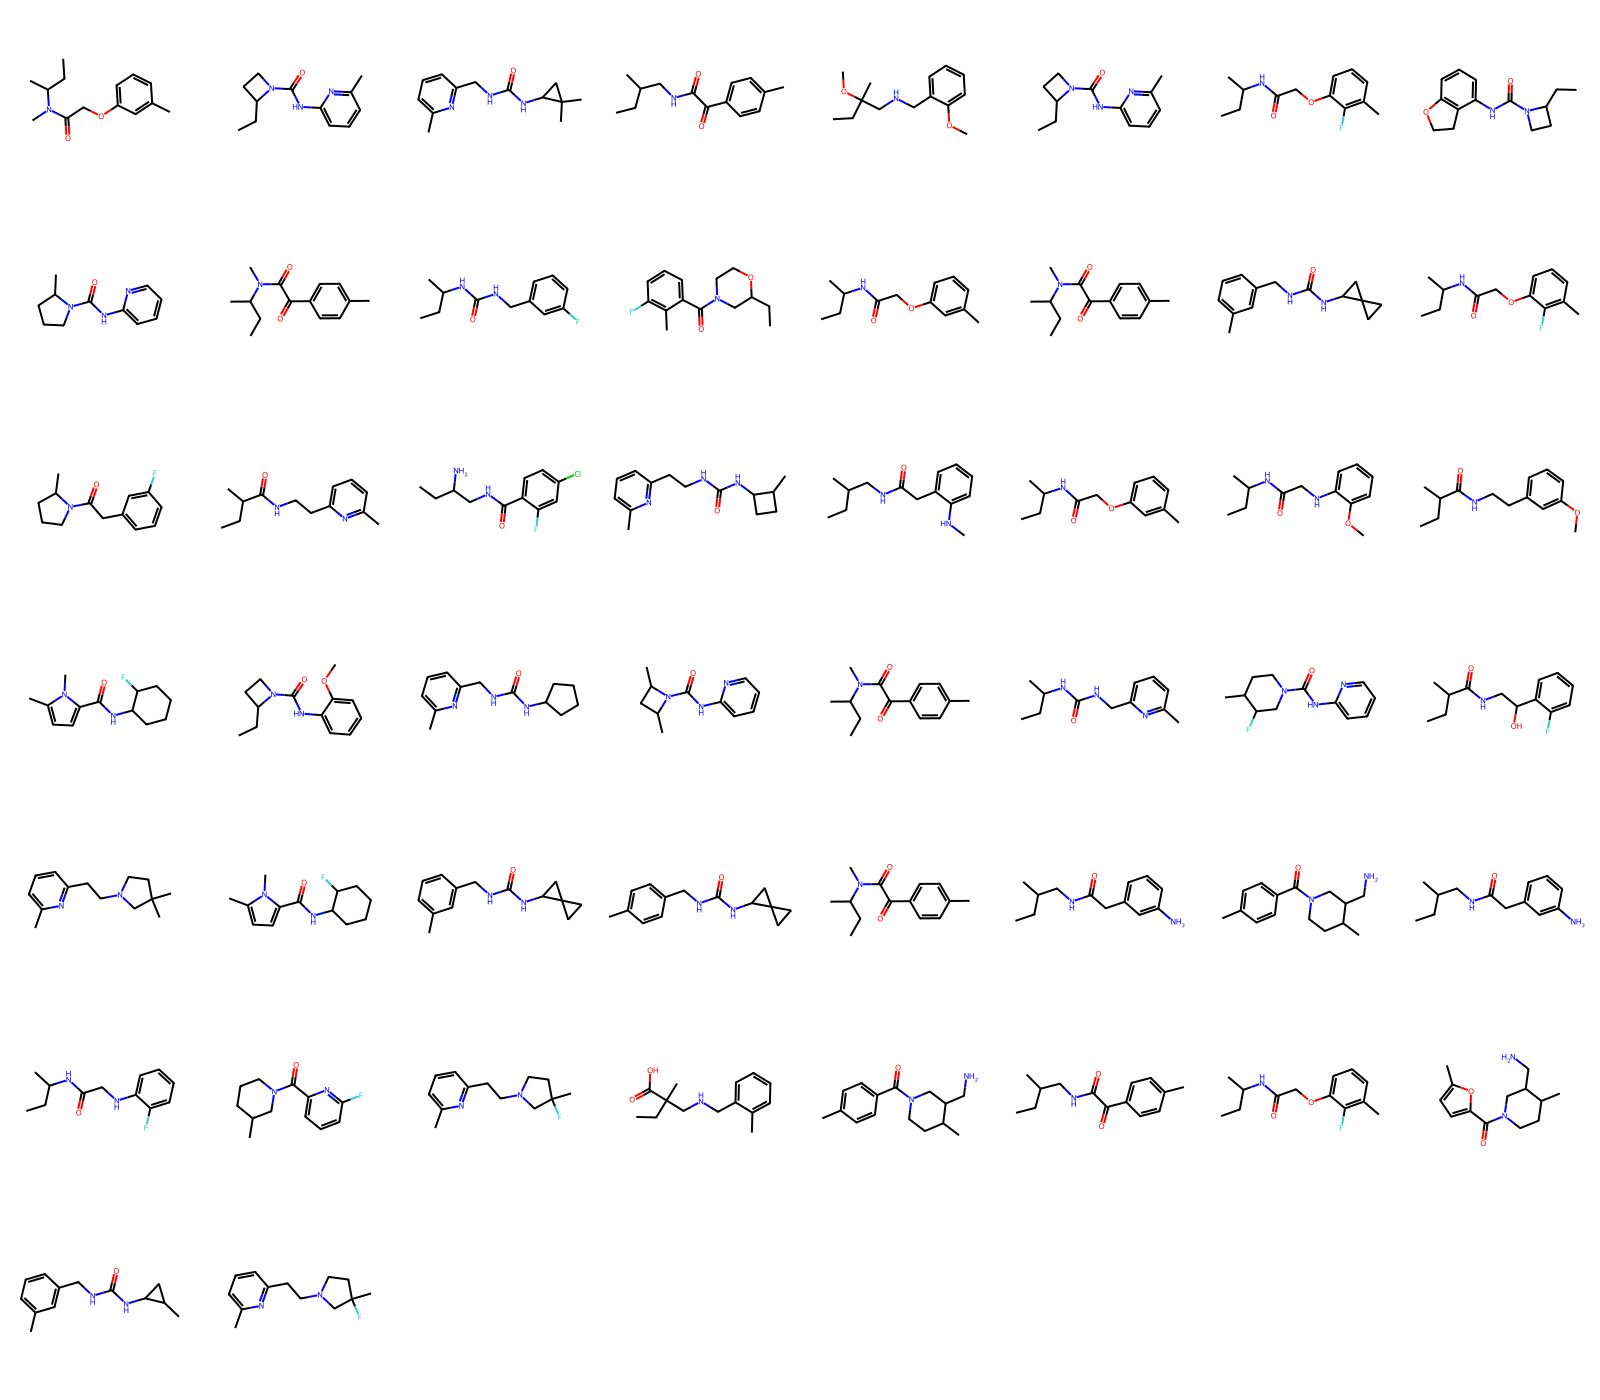

In [62]:
from rdkit import Chem

mols = [Chem.MolFromSmiles(x) for x in smiles_gen]
Chem.Draw.MolsToGridImage(mols, molsPerRow=8)

In [63]:
import pandas as pd

predictions = pd.DataFrame(smiles_gen, columns=["SMILES"])
predictions["mol"] = [Chem.MolFromSmiles(x) for x  in predictions.SMILES]
predictions.dropna(inplace=True)
predictions["mw"] = [Chem.rdMolDescriptors.CalcExactMolWt(mol) for mol in predictions.mol]
predictions["tpsa"] = [Chem.rdMolDescriptors.CalcTPSA(mol) for mol in predictions.mol]
predictions["sp3"]=[Chem.rdMolDescriptors.CalcFractionCSP3(mol) for mol in predictions.mol]
predictions["n_arings"]=[Chem.rdMolDescriptors.CalcNumAromaticRings(mol) for mol in predictions.mol]
predictions["h_don"] = [Chem.rdMolDescriptors.CalcNumLipinskiHBD(mol) for mol in predictions.mol]
predictions["h_acc"] = [Chem.rdMolDescriptors.CalcNumLipinskiHBA(mol) for mol in predictions.mol]
similarity = []

ref_fp = Chem.AllChem.GetMorganFingerprintAsBitVect(ref_mol,2,nBits=2048)
for mol in predictions.mol:
    fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048)
    similarity.append(Chem.AllChem.DataStructs.FingerprintSimilarity(ref_fp,fp))

predictions["similarity"] = similarity

fig, axs = plt.subplots(2,3,figsize=(15,12))

axs[0,0].hist(predictions.sp3)
axs[0,0].axvline(Chem.rdMolDescriptors.CalcFractionCSP3(ref_mol),0,1, color="red")
axs[0,0].set_title("Fraction SP3")
axs[0,1].hist(predictions.n_arings)
axs[0,1].axvline(Chem.rdMolDescriptors.CalcNumAromaticRings(ref_mol),0,1, color="red")
axs[0,1].set_title("Num Arom Rings")
axs[0,2].hist(predictions.mw)
axs[0,2].axvline(Chem.rdMolDescriptors.CalcExactMolWt(ref_mol),0,1, color="red")
axs[0,2].set_title("MW")
axs[1,0].hist(predictions.h_don)
axs[1,0].axvline(Chem.rdMolDescriptors.CalcNumLipinskiHBD(ref_mol),0,1, color="red")
axs[1,0].set_title("Num H_donors")
axs[1,1].hist(predictions.h_acc)
axs[1,1].axvline(Chem.rdMolDescriptors.CalcNumLipinskiHBA(ref_mol),0,1, color="red")
axs[1,1].set_title("Num H_acceptors")
axs[1,2].hist(predictions.tpsa)
axs[1,2].axvline(Chem.rdMolDescriptors.CalcTPSA(ref_mol),0,1, color="red")
axs[1,2].set_title("TPSA")

In [4]:
# predictions = pd.read_csv("../reports/AZD_generated_tr200000.csv", index_col=0)

Text(0.5, 1.0, 'TPSA')

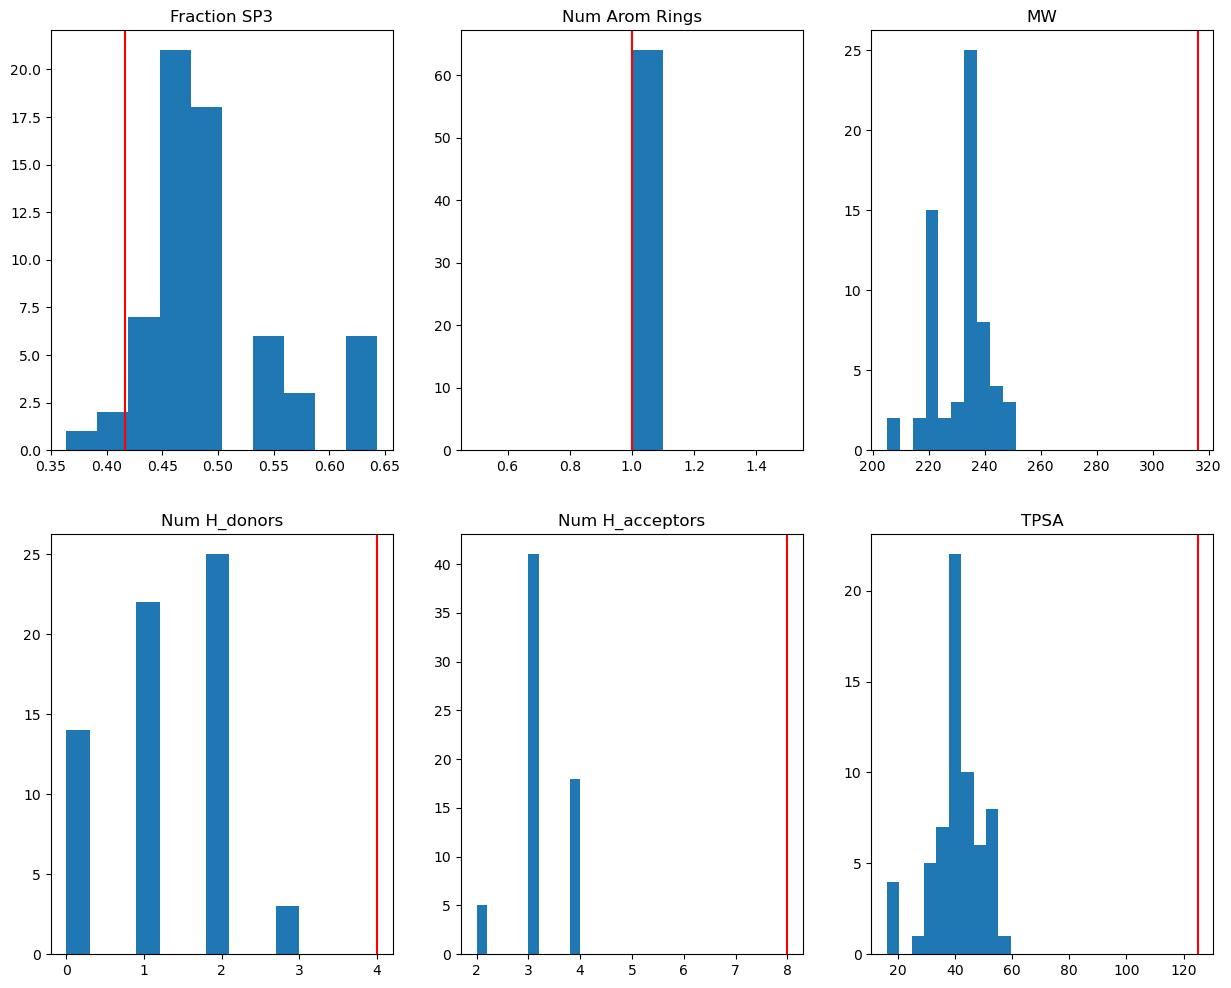

In [64]:
fig, axs = plt.subplots(2,3,figsize=(15,12))

axs[0,0].hist(predictions.sp3)
axs[0,0].axvline(Chem.rdMolDescriptors.CalcFractionCSP3(ref_mol),0,1, color="red")
axs[0,0].set_title("Fraction SP3")
axs[0,1].hist(predictions.n_arings)
axs[0,1].axvline(Chem.rdMolDescriptors.CalcNumAromaticRings(ref_mol),0,1, color="red")
axs[0,1].set_title("Num Arom Rings")
axs[0,2].hist(predictions.mw)
axs[0,2].axvline(Chem.rdMolDescriptors.CalcExactMolWt(ref_mol),0,1, color="red")
axs[0,2].set_title("MW")
axs[1,0].hist(predictions.h_don)
axs[1,0].axvline(Chem.rdMolDescriptors.CalcNumLipinskiHBD(ref_mol),0,1, color="red")
axs[1,0].set_title("Num H_donors")
axs[1,1].hist(predictions.h_acc)
axs[1,1].axvline(Chem.rdMolDescriptors.CalcNumLipinskiHBA(ref_mol),0,1, color="red")
axs[1,1].set_title("Num H_acceptors")
axs[1,2].hist(predictions.tpsa)
axs[1,2].axvline(Chem.rdMolDescriptors.CalcTPSA(ref_mol),0,1, color="red")
axs[1,2].set_title("TPSA")

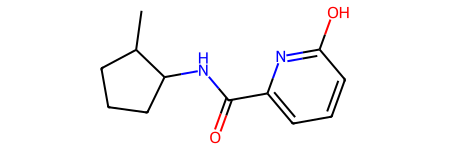

In [57]:
predictions.sort_values("similarity", ascending=False).reset_index(drop=True).mol[3]

In [25]:
predictions.sort_values("similarity", ascending=False)

SMILES  \
60   CC(C)C(N)C(=O)NCC(C)(C)c1ccccc1   
50   CC(C)C(N)C(=O)NCC(C)(C)c1ccccc1   
6    CC(C)C(N)C(=O)NCC(C)(C)c1ccccc1   
48   CC(C)C(N)C(=O)NCC(C)(C)c1ccccc1   
9    CC(C)C(N)C(=O)NCC(C)(C)c1ccccc1   
..                               ...   
39  CC(C)C(N)C(=O)NCC1CCCN1CC(F)(F)F   
26    CC(C)CC(CN)NC(=O)NCC1CCCC(C)O1   
7     CC(C)CC(CN)NC(=O)NCC1CCCC(C)O1   
3     CC(C)CC(CN)NC(=O)NCC1CCCC(C)O1   
32    CC(C)CC(CN)NC(=O)NCC1CCCC(C)O1   

                                                 mol          mw   tpsa  \
60  <rdkit.Chem.rdchem.Mol object at 0x7f129fe3a7b0>  248.188863  55.12   
50  <rdkit.Chem.rdchem.Mol object at 0x7f12b27a3660>  248.188863  55.12   
6   <rdkit.Chem.rdchem.Mol object at 0x7f129d3d46d0>  248.188863  55.12   
48  <rdkit.Chem.rdchem.Mol object at 0x7f12b27a3580>  248.188863  55.12   
9   <rdkit.Chem.rdchem.Mol object at 0x7f129d3d4580>  248.188863  55.12   
..                                               ...         ...    ...   
39  <rdkit.Chem.rdchem.Mol object at 0x7f12b27a3190>  281.171497  58.36   
26  <rdkit.Chem.rdchem.Mol object at 0x7f12b279ec10>  271.225977  76.38   
7   <rdkit.Chem.rdchem.Mol object at 0x7f129d3d4660>  271.225977  76.38   
3   <rdkit.Chem.rdchem.Mol object at 0x7f129d3d4820>  271.225977  76.38   
32  <rdkit.Chem.rdchem.Mol object at 0x7f129d3b0e40>  271.225977  76.38   

         sp3  n_arings  h_don  h_acc  similarity  
60  0.533333         1      3      3    0.250000  
50  0.533333         1      3      3    0.250000  
6   0.533333         1      3      3    0.250000  
48  0.533333         1      3      3    0.250000  
9   0.533333         1      3      3    0.250000  
..       ...       ...    ...    ...         ...  
39  0.916667         0      3      4    0.125000  
26  0.928571         0      4      5    0.089552  
7   0.928571         0      4      5    0.089552  
3   0.928571         0      4      5    0.089552  
32  0.928571         0      4      5    0.089552  

[64 rows x 9 columns]

In [104]:
predictions.drop("mol", axis=1).to_csv("../reports/lily_generated_tr400000.csv")